In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sts

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

[&#39;measurement&#39;, &#39;station&#39;]

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Preview the Measurement table
pd.read_sql_table('measurement', engine).head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [10]:
# Preview the Station table
pd.read_sql_table('station', engine).head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Calculate the date 1 year ago from the last data point in the database
engine.execute('Select max(date) from measurement').fetchall()

[(&#39;2017-08-23&#39;,)]

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores ordered by date
df = pd.read_sql("select date, sum(prcp) as prcp from measurement where date >= '2016-08-23' group by date order by date", engine)
# Save the query results as a Pandas DataFrame and set the index to the date column
df = df.set_index('date')
df.head(10)

,prcp
date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10
2016-08-29,1.46
2016-08-30,0.07
2016-08-31,3.18


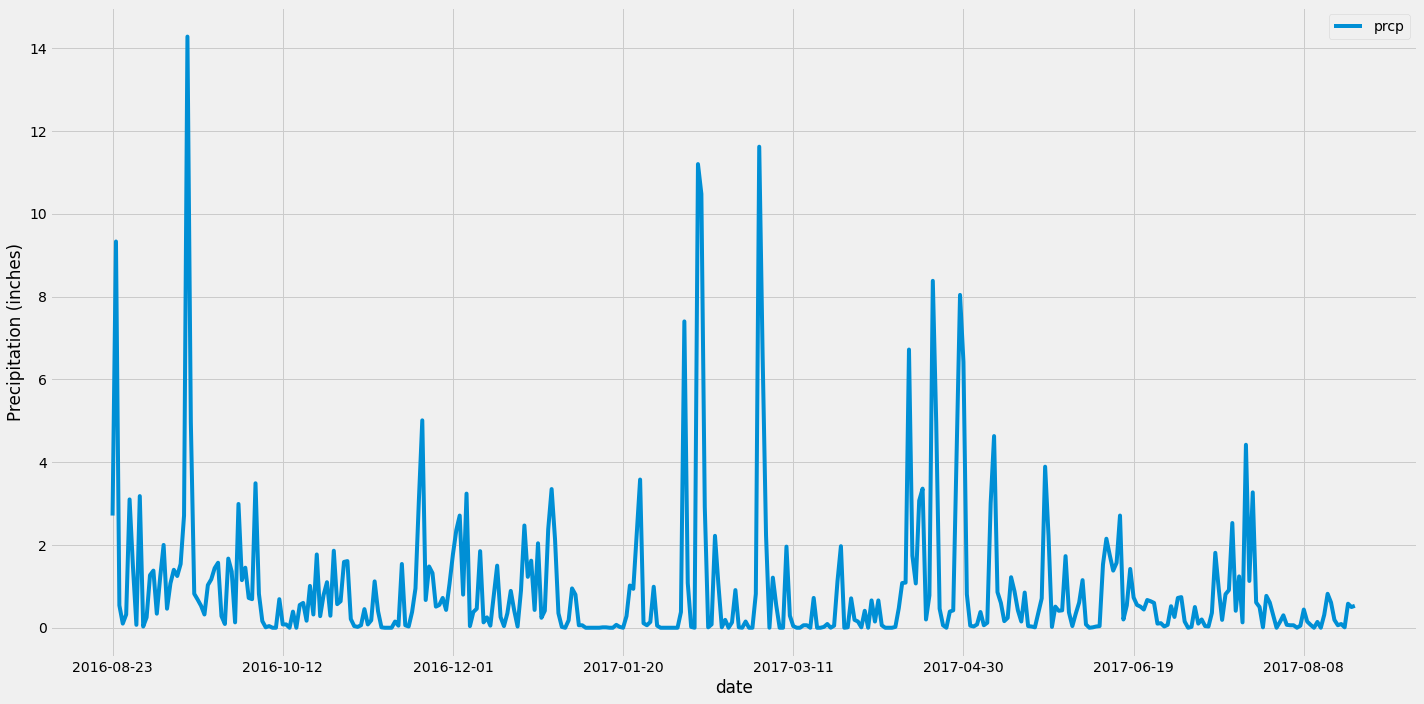

In [14]:
# Plot the results using the DataFrame `plot` method.
df.plot(figsize=(20,10))
plt.ylabel('Precipitation (inches)')
plt.tight_layout()
plt.savefig("Images/Precipitation.png")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp = df['prcp']
summary = pd.DataFrame(prcp.describe())
summary

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [16]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).count()
print(stations)

9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = pd.read_sql("select station, count(station) as station_count from measurement group by station order by station_count desc", engine)
active_stations

,station,station_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
low_temp = pd.read_sql("select min(tobs) as Lowest_Temp from measurement where station='USC00519281'", engine)

print(f"Lowest recorded temperature at station USC00519281 is {float(low_temp['Lowest_Temp'])}")

Lowest recorded temperature at station USC00519281 is 54.0


In [19]:
# highest temperature recorded, and average temperature of the most active station?
high_temp = pd.read_sql("select max(tobs) as Highest_Temp from measurement where station='USC00519281'", engine)

print(f"Highest recorded temperature at station USC00519281 is {float(high_temp['Highest_Temp'])}")

Highest recorded temperature at station USC00519281 is 85.0


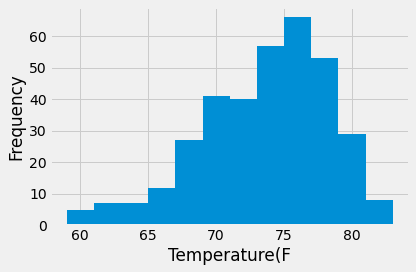

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281 = pd.read_sql("select tobs from measurement where date >= '2016-08-23' and station='USC00519281' group by date order by date", engine)
plt.hist(USC00519281['tobs'], bins=12)
plt.xlabel('Temperature(F')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("Images/temp_histogram.png")
plt.show()

## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp_list = calc_temps('2017-05-10', '2017-05-16')
print(trip_temp_list)

[(70.0, 75.38461538461539, 79.0)]


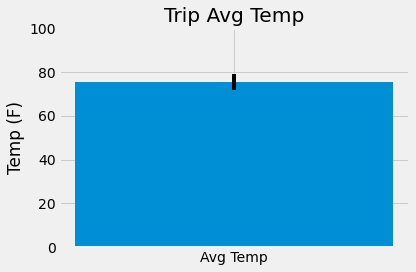

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temps = trip_temp_list[0]
min_temp = trip_temps[0]
avg_temp = trip_temps[1]
max_temp = trip_temps[2]
error = np.std(trip_temps)
plt.bar("Avg Temp",avg_temp, align='center', yerr=error)
plt.ylim(0,100)
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.tight_layout()
plt.savefig("Images/trip_avg_temp.png")
plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results = pd.read_sql("select Measurement.station, sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation from measurement join station on measurement.station = station.station where Measurement.date >= '2017-05-10' and Measurement.date <= '2017-05-16' group by Measurement.station order by sum(Measurement.prcp) desc", engine)
results

,station,sum(Measurement.prcp),name,latitude,longitude,elevation
0,USC00516128,3.09,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,0.75,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,0.30,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,0.12,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00519397,0.07,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,USC00514830,0.05,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
# https://stackoverflow.com/questions/993358/creating-a-range-of-dates-in-python
start = dt.datetime.strptime("2017-05-10", "%Y-%m-%d")
end = dt.datetime.strptime("2017-05-16", "%Y-%m-%d")

# Use the start and end date to create a range of dates
date_generated = [start + dt.timedelta(days=x) for x in range(0, (end-start).days)]

# Strip off the year and save a list of %m-%d strings
date_list = []
for date in date_generated:
    date_list.append(date.strftime("%m-%d"))

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in date_list:
    normal = list(np.ravel(daily_normals(date)))
    normals.append(normal)
normals

[[64.0, 73.3157894736842, 78.0],
 [65.0, 73.61111111111111, 79.0],
 [65.0, 73.13793103448276, 79.0],
 [67.0, 73.14285714285714, 79.0],
 [63.0, 73.89285714285714, 80.0],
 [63.0, 73.69090909090909, 79.0]]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_summary = pd.DataFrame(normals, columns=['Min', 'Avg', 'Max'])
trip_summary['dates'] = date_list
trip_summary = trip_summary.set_index('dates')
trip_summary

,Min,Avg,Max
dates,,,
05-10,64.0,73.315789,78.0
05-11,65.0,73.611111,79.0
05-12,65.0,73.137931,79.0
05-13,67.0,73.142857,79.0
05-14,63.0,73.892857,80.0
05-15,63.0,73.690909,79.0


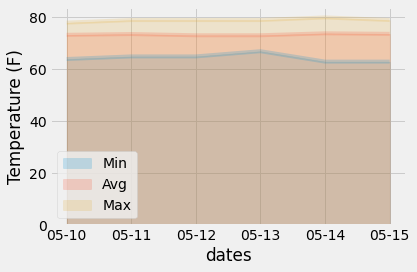

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
trip_summary.plot(kind='area',stacked=False, alpha=0.2)
plt.ylabel('Temperature (F)')
plt.tight_layout()
plt.savefig("Images/normals.png")